In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [17]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'
# PATH_TO_ST = '../data_in/ciapitof_raw_filtered.csv'

PATH_200_CLUS = '../data_out/cluster1000.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
}

In [18]:
df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)

for l, c in zip(COLS, LCOLS):
    df[c] = np.log10(df[l])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

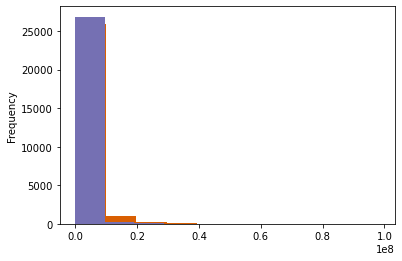

In [19]:
for c in COLS:
    df[c].plot.hist(color=DC[c])

Text(0.5, 0, 'log10')

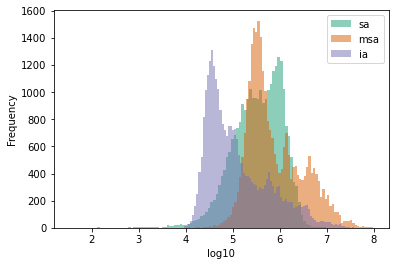

In [20]:
for c in COLS:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 200 clusters

In [21]:
ds = xr.open_dataset(PATH_200_CLUS)

In [22]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

q0, q1 = np.quantile(dsf.values.flatten(), [.01, .99])



# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsf.columns, axf):
#     ax.hist(np.log10(dsf[i] + q0), bins=np.linspace(np.log10(q0), np.log10(q1 + q0), 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [23]:
dsfn = dsf / dsf.mean()

In [24]:
q0, q1 = dsfn.stack().quantile([.01, .99])

In [25]:
# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsfn.columns, axf):
#     ax.hist(dsfn[i], bins=np.linspace(q0, q1, 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [26]:
df1 = df

In [27]:
df2 = df1.resample('3H').median()

In [28]:
dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")

# Invers modeling elastic NET

174.16638722962904 0.99999


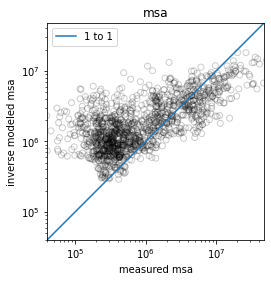

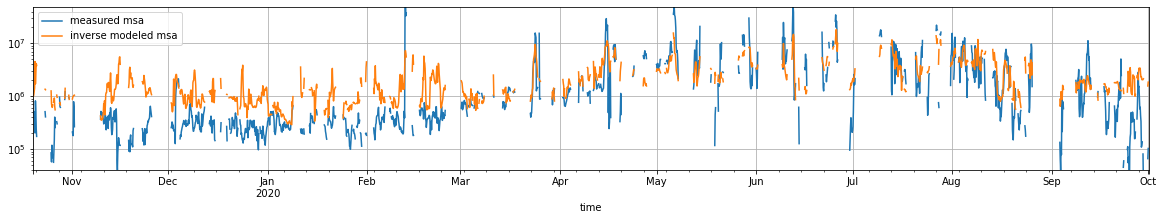

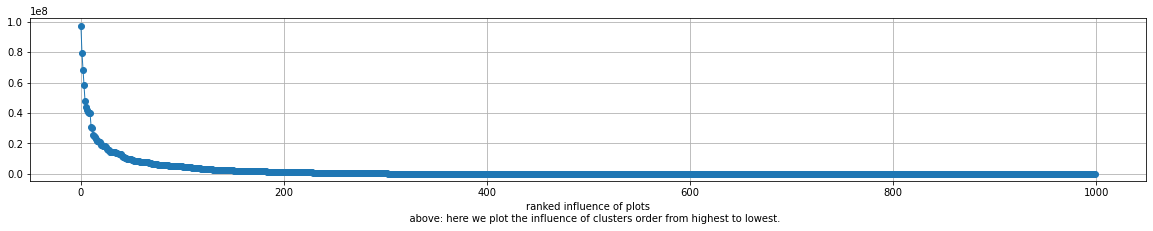

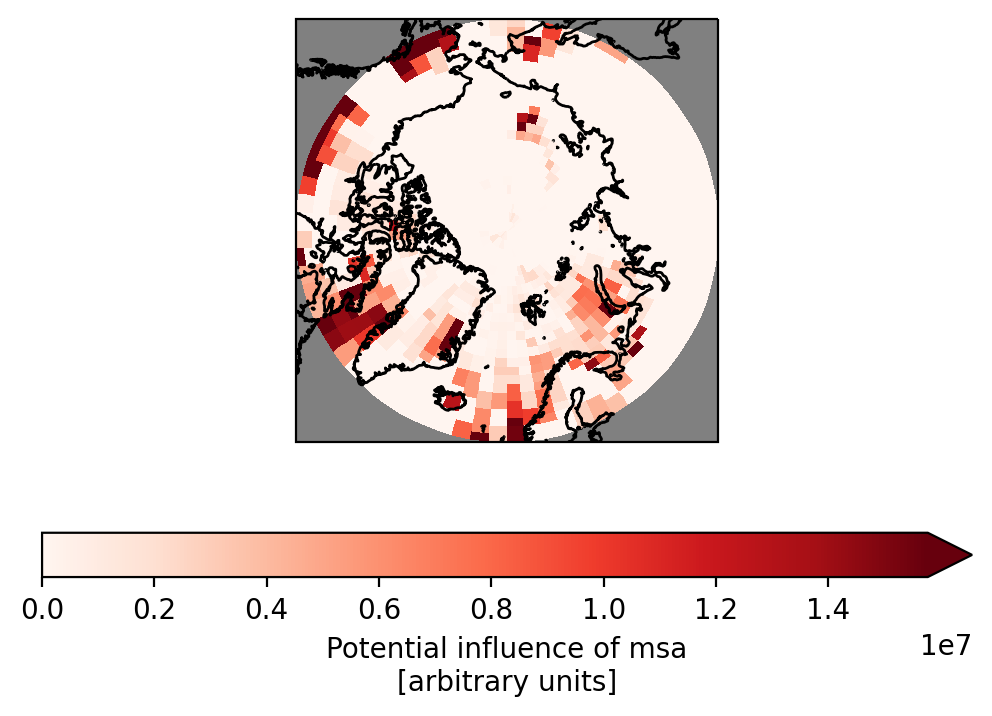

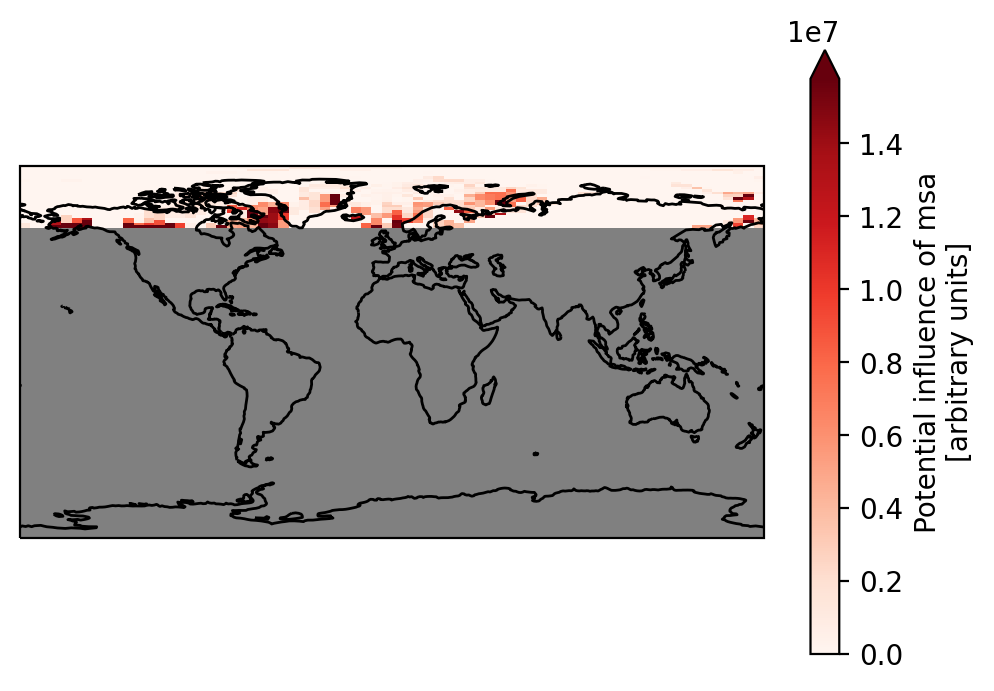

In [29]:
# for PAR in [SA,MSA,IA]:
for PAR in [MSA]:
    pred, cdf, y, yn, dp = rfu.elastic_net_reg(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds,PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)

In [30]:
cdf.sort_values(ascending=False)

lab
984    97683720.0
988    79771304.0
990    68519040.0
982    58496044.0
985    48282884.0
          ...    
200           0.0
198           0.0
537           0.0
538           0.0
999           0.0
Length: 1000, dtype: float32

In [31]:
import funs as fu

In [32]:
d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

In [33]:
df1[G] = df.apply(fu.get_pol, axis=1)

In [34]:
import geopandas
dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

In [35]:
cdf.name = 'infl'

In [36]:
df2 = pd.merge(dg1,cdf,left_index=True,right_index=True)

In [37]:
df3 = df2.sort_values('infl',ascending=False).iloc[:20]

In [38]:
df3['infl']

lab
984    97683720.0
988    79771304.0
990    68519040.0
982    58496044.0
985    48282884.0
989    43902204.0
972    42349184.0
960    41000316.0
955    40278776.0
901    39887820.0
971    31071598.0
910    30064936.0
991    25872506.0
979    25165564.0
581    23962024.0
892    23044586.0
934    21522202.0
973    21435118.0
913    21211464.0
969    20966354.0
Name: infl, dtype: float32

In [39]:
dm1 = dm[df3.index]

In [40]:
dm2 = dm1/dm1.sum()
dm2 = (dm1 * df3['infl'])/100000

In [41]:
cmap = plt.get_cmap('tab20')

In [42]:
co = dm2.columns

In [917]:
q1,q2=dm2.stack().quantile([.001,.999])

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


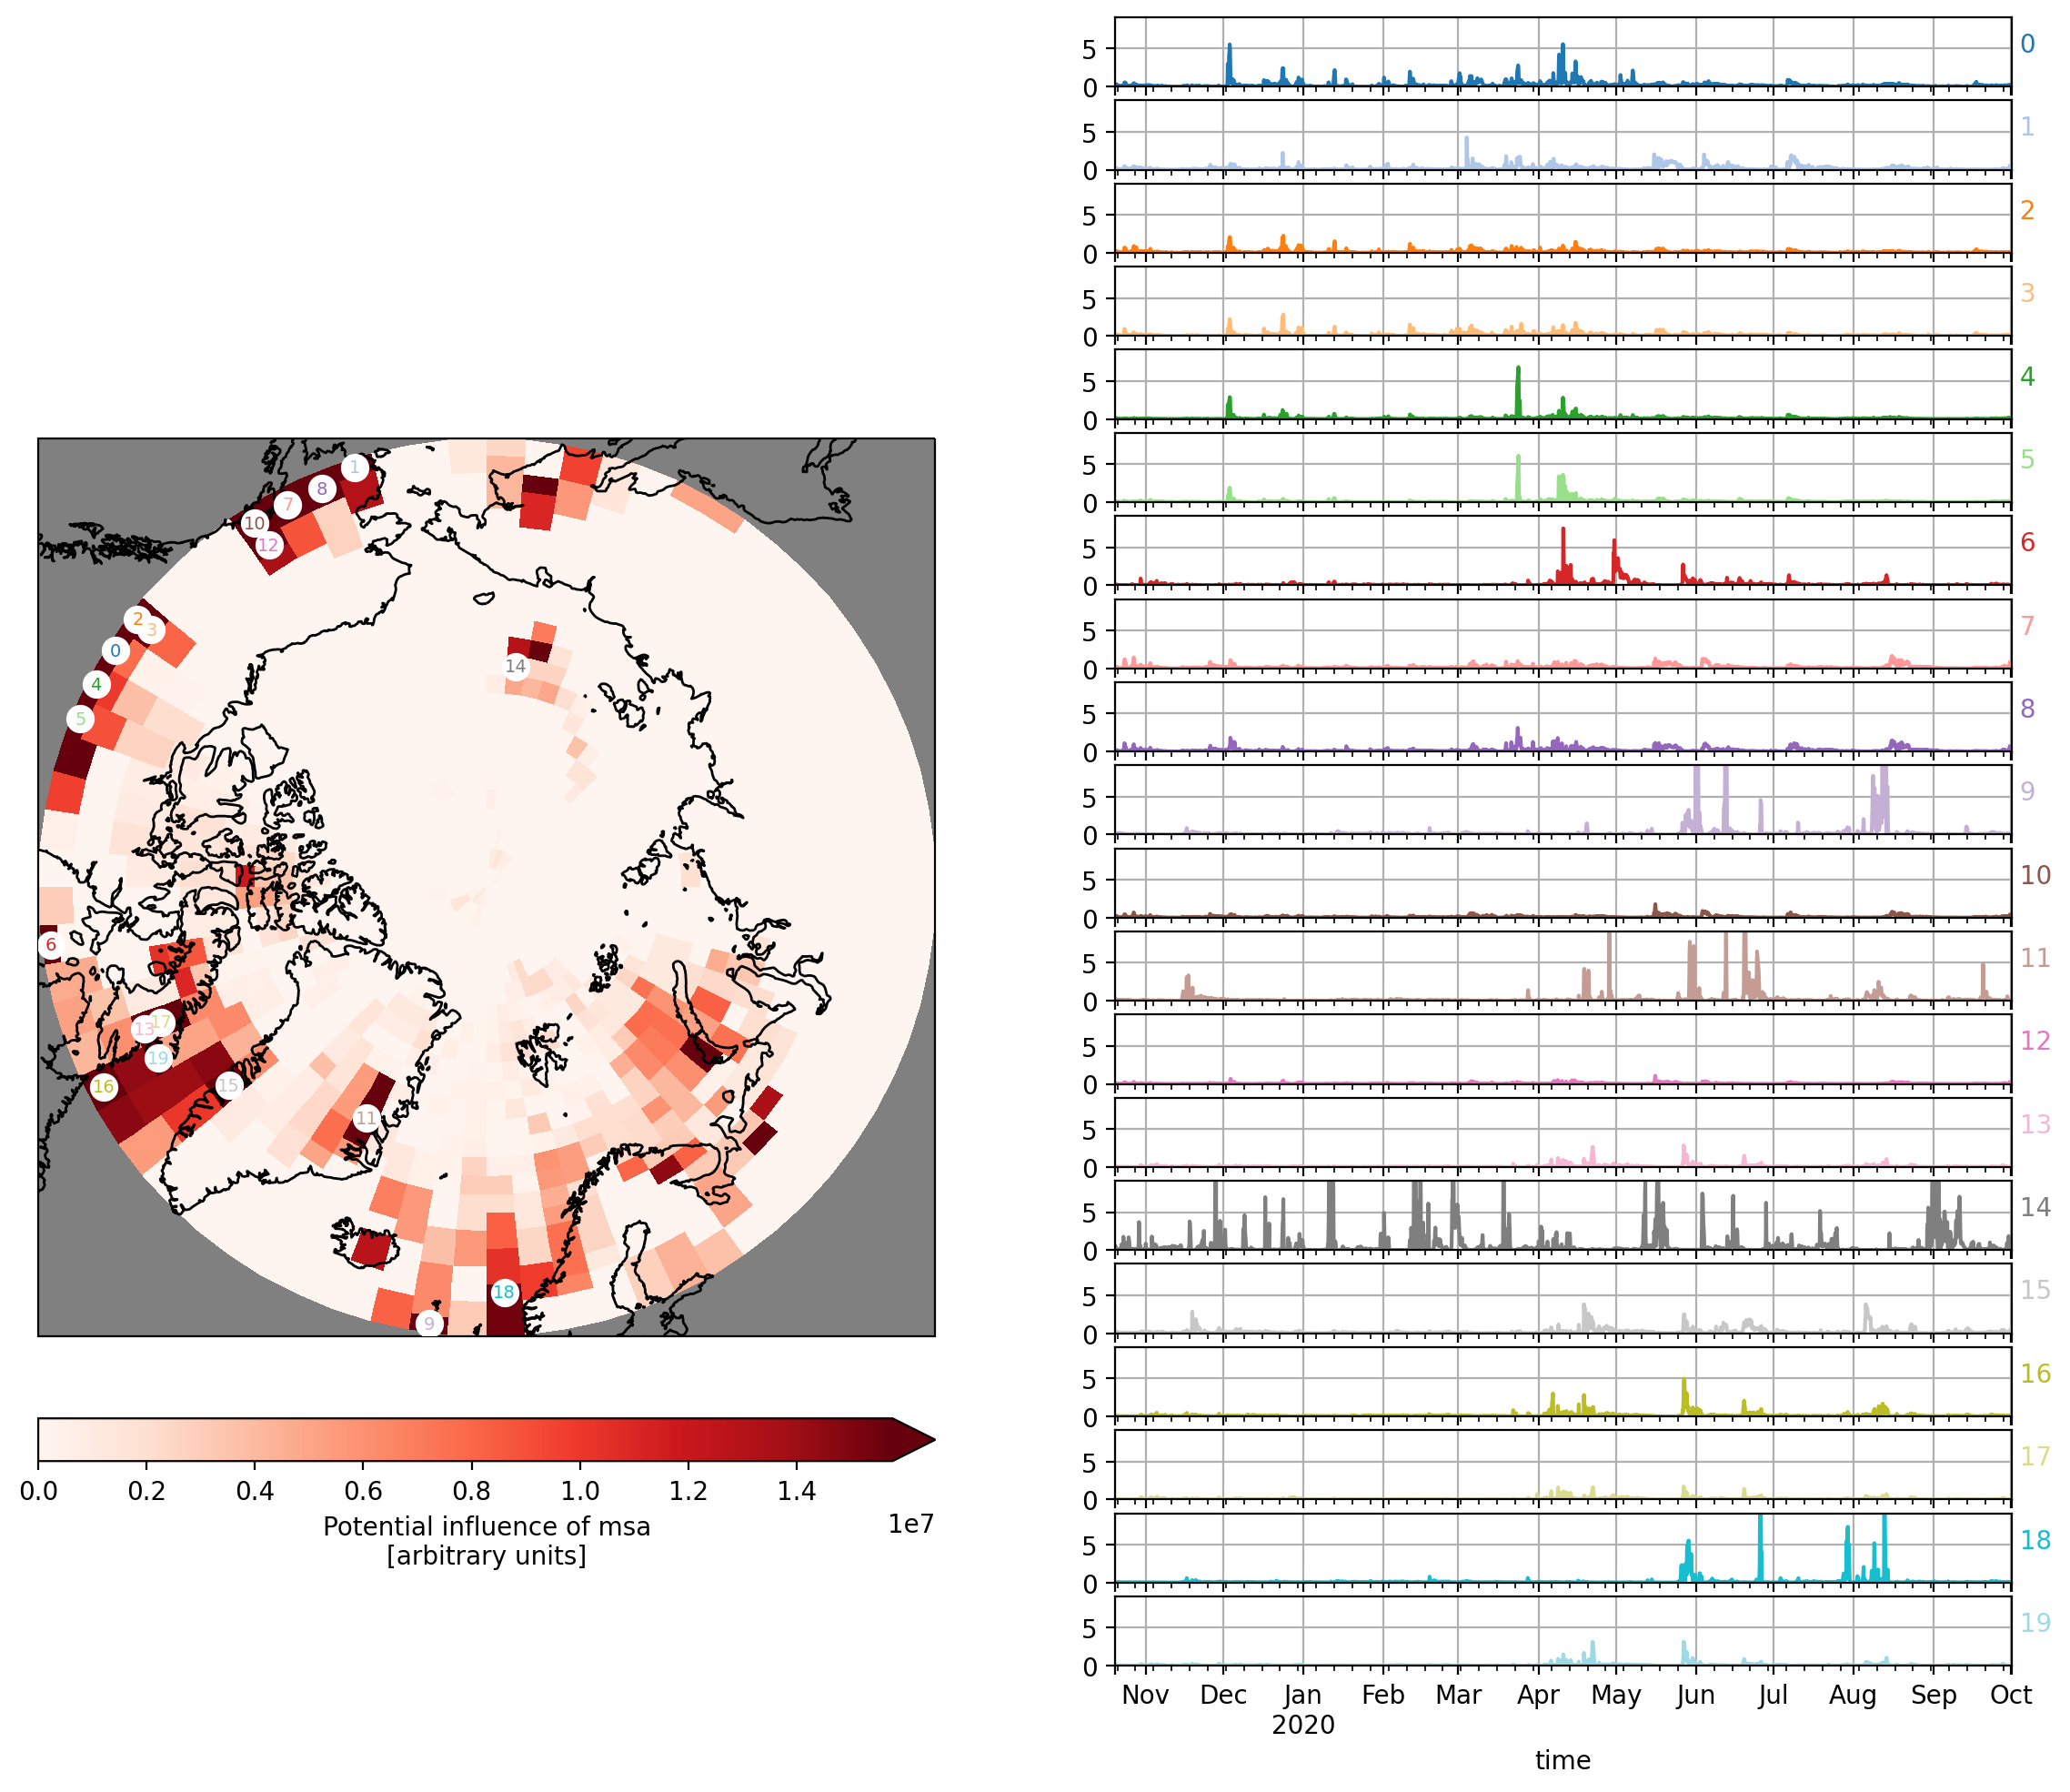

In [918]:
lco = len(co)

f = plt.figure(constrained_layout=True,figsize=(2*7,lco*.6),dpi=200)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(lco,2)




# f,axs=plt.subplots(lco,dpi=200,sharex=True,sharey=True,figsize=(7,lco*.6))


ax0 = None
for i,c in enumerate(co):
    ax = f.add_subplot(gs[i, 1],sharex=ax0)
    if i == 0: ax0 = ax
    (dm2[c]).plot(c=cmap(i),ax=ax)
    ax.text(1,.5,f' {i}',transform=ax.transAxes,c=cmap(i))
    ax.grid()
    ax.set_ylim(0,q2*1.1)
# ax=plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(q1,q2)
# ax.legend(bbox_to_anchor=(1,1))


import cartopy.crs as ccrs
ax = f.add_subplot(gs[:,0],projection=ccrs.Orthographic(0, 90), facecolor="gray")
rfu.plot_map(dd2,ax=ax)
# ax=plt.gca()
for i,c in enumerate(co):
    p =df3.centroid[c]
    ax.scatter( p.x,p.y,transform=ccrs.PlateCarree(),c='w',s=105,alpha=1,zorder=19)
    ax.text( p.x,p.y,i,transform=ccrs.PlateCarree(),c=cmap(i),va='center',ha='center',fontsize=7,zorder = 20)



In [919]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
    regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
#     regr = ElasticNet( random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf / xn

In [920]:
regr = ElasticNetCV(alphas=.5,cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

In [921]:
ii = [.1, .5, .7, .9, .95, .99,.999,.9999,.99999, 1]

In [922]:
regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
regr.fit(XX[yn], y[yn])

ElasticNetCV(cv=5, fit_intercept=False,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999,
                       1],
             positive=True, random_state=0)

In [923]:
al_,l1_=regr.alpha_, regr.l1_ratio_
al_,l1_

(174.16638722962904, 0.99999)

In [924]:
ccs = {}
r = {}
rmsd = {}
for a in [0,*np.geomspace(.01,1000*al_,201)]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    
#     
    regr = ElasticNet(alpha=a, random_state=2346, positive=True, l1_ratio=l1_, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    
    sd_=np.sqrt((y[yn]**2).mean())
    rmsd_ = np.sqrt((((pred - y[yn]))**2).mean())/sd_
    rmsd[a] = rmsd_
    
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
    cdf = cdf/cdf.sum()
    ccs[a]=cdf
    r[a]=regr.score(XX[yn], y[yn])

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_97438/3500564823.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr.fit(XX[yn], y[yn])
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.250e+15, tolerance: 5.169e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


In [925]:
al_

174.16638722962904

<AxesSubplot:>

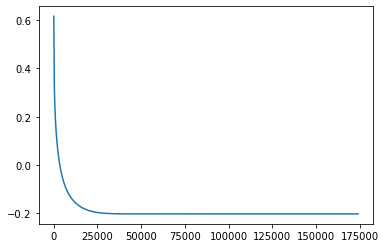

In [926]:
pd.Series(r).plot()

<AxesSubplot:>

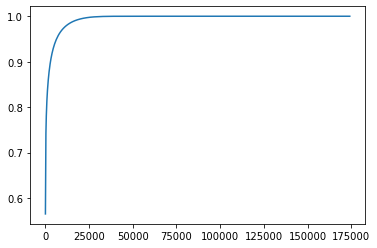

In [927]:
pd.Series(rmsd).plot()

In [928]:
ddd = pd.DataFrame(ccs).T

In [929]:
ddd

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0.000000,0.021124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.010000,0.021129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.010869,0.021129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.011814,0.021130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.012841,0.021130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124780.021581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135628.162556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147419.420556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160235.788405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [930]:
l = []
for a,r in ddd.iloc[::-1].iloc[::].iterrows():
    
    rr = r[~r.index.isin(l)]

    try:
        iii = rr.idxmax()
    #     print(iii)
        if rr.sum() == 0:
            continue
#             print(a)
        l.append(iii)
    except:
        break
    
    

In [931]:
len(l)

114

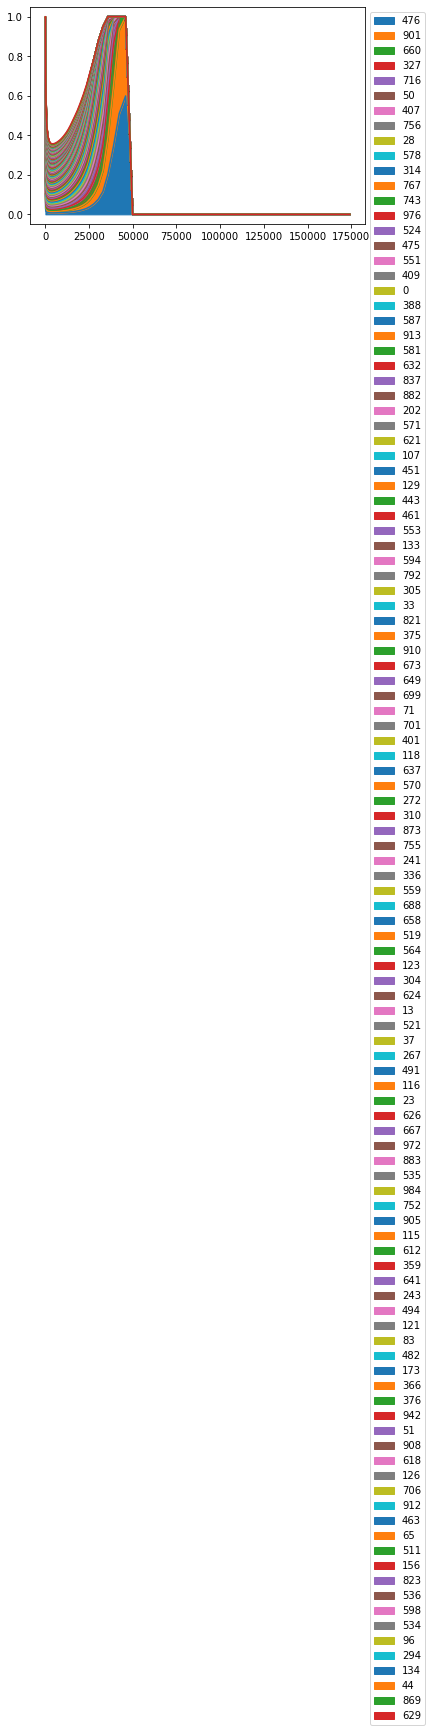

In [932]:
ddd[l].plot.area()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1,1))
# ax.legend().remove()

In [933]:
rem = set(ddd.columns)-set(l)
l1 = [*l,*rem]

In [934]:
dd = pd.Series(l1).reset_index().set_index(0)['index'].to_dict()

In [935]:
ds2 = ds[L].to_series().replace(dd).to_xarray()

In [936]:
ds

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 24, time: 3021)
Coordinates:
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat        (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * time       (time) datetime64[ns] 2019-09-20T09:00:00 ... 2020-10-01T21:00:00
    lab        (lat, lon) int64 837 917 976 831 825 815 ... 463 294 294 294 294
Data variables:
    AIRTRACER  (time, lat, lon) float32 0.0004269 0.0001852 ... 0.0002132

In [937]:
q1,q2 = ds[AT].sum('time').quantile([.01,.5])

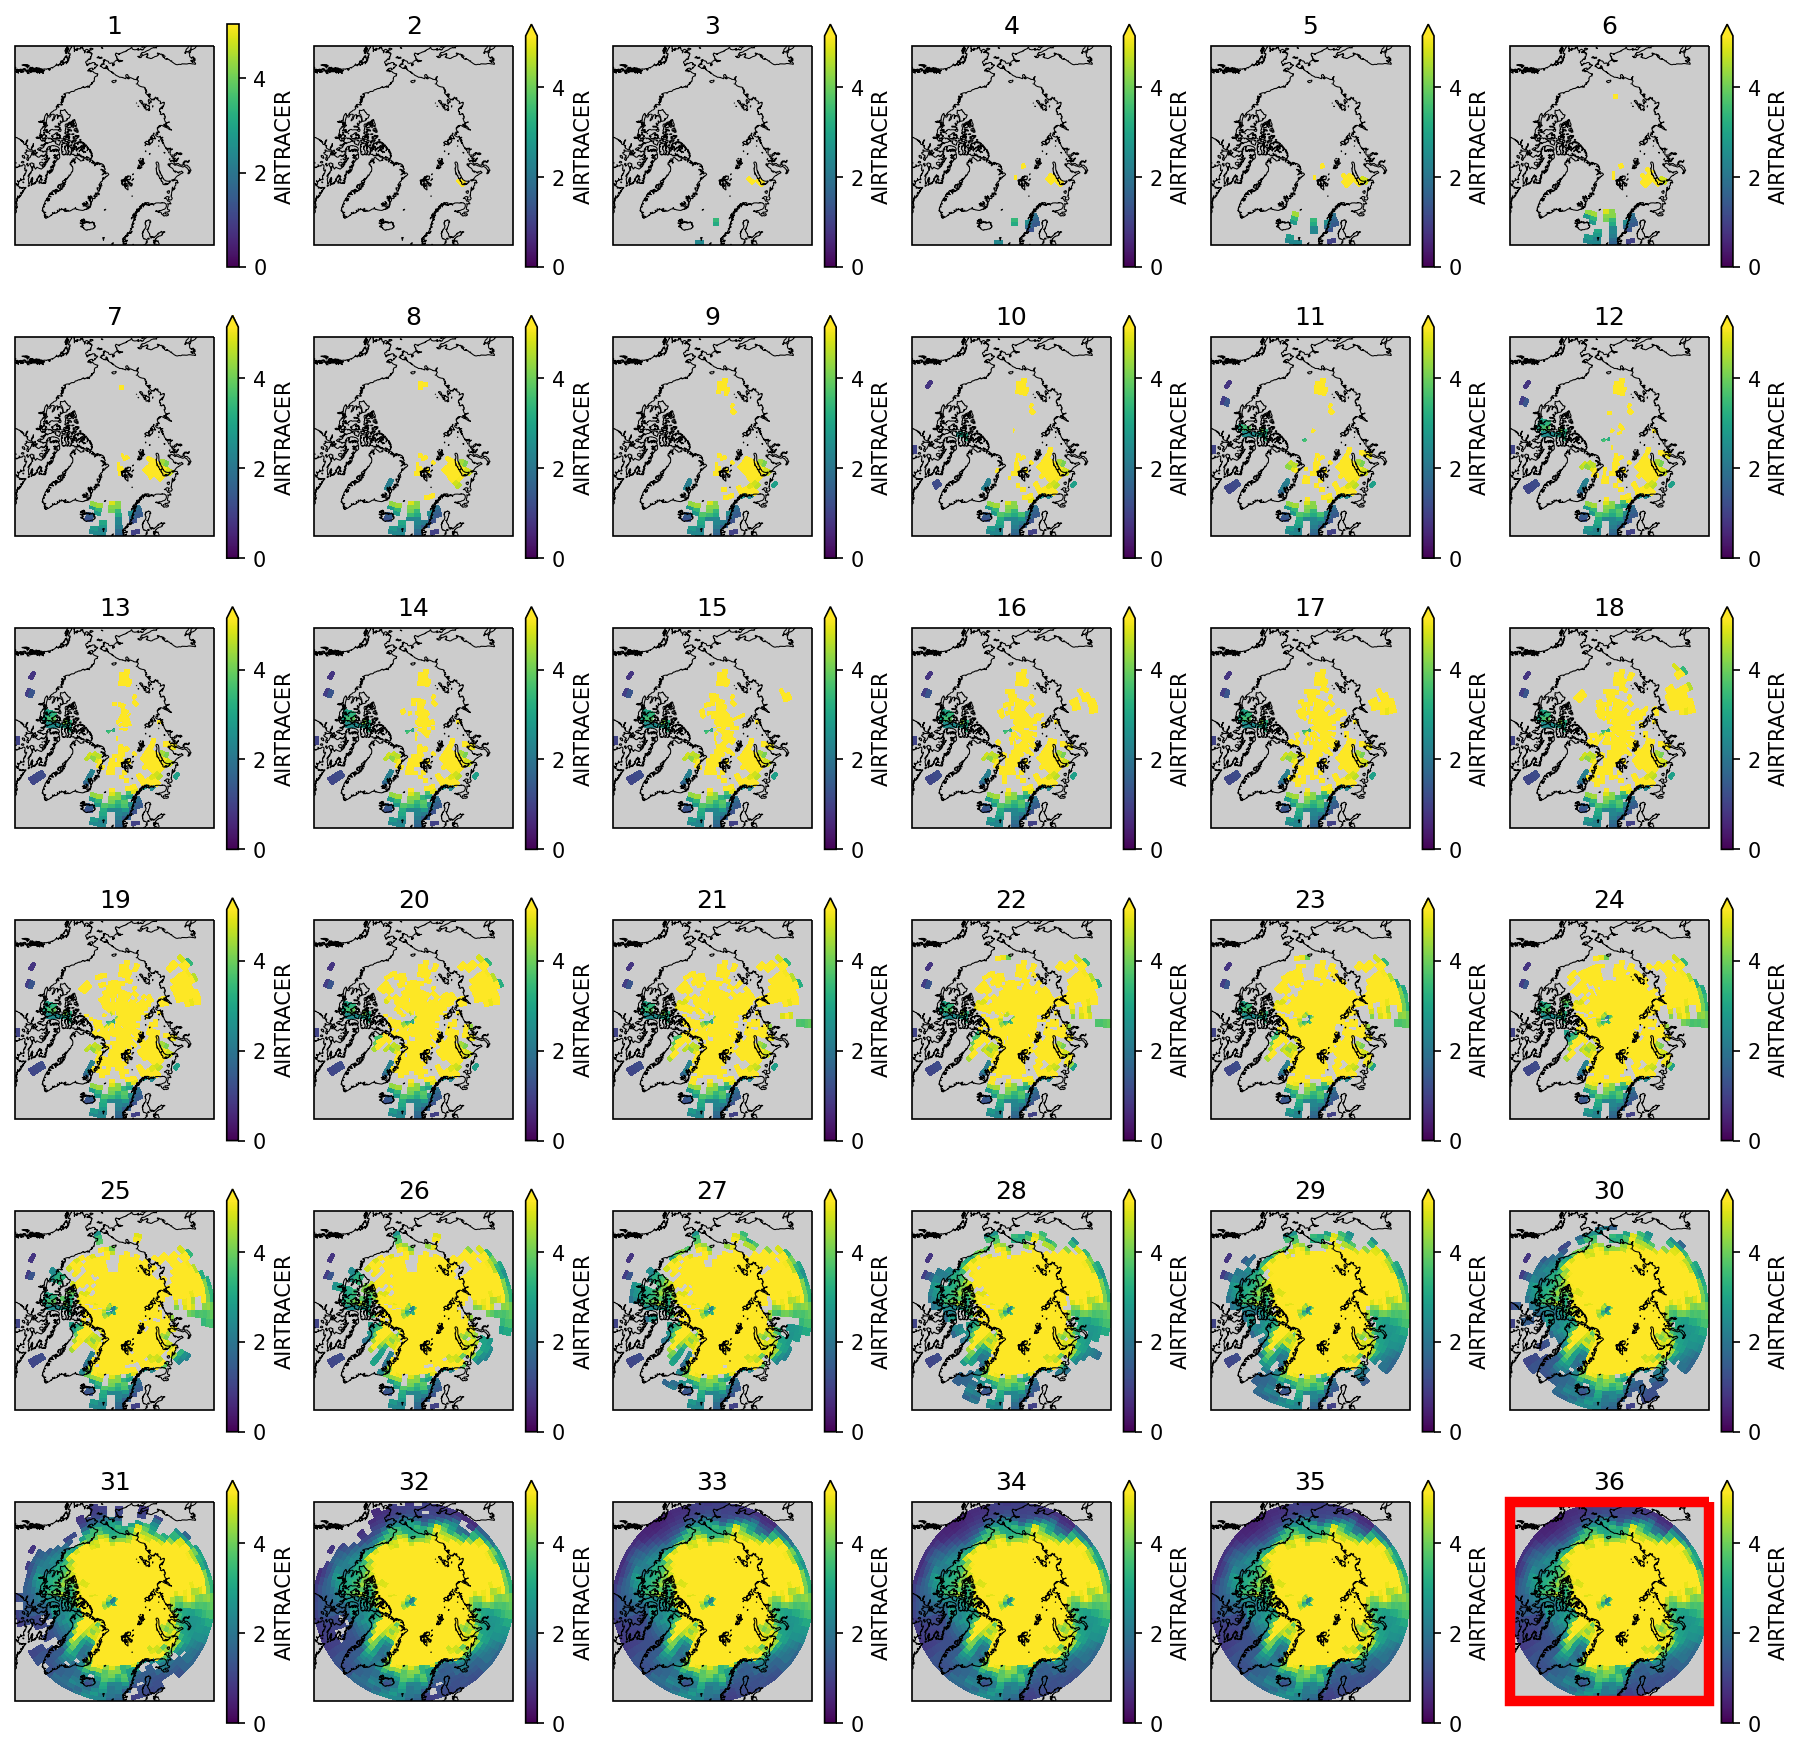

In [938]:
AA=35
import matplotlib as mpl
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")


f, axs = plt.subplots(6,6,subplot_kw=dic, sharex=True,sharey=True,figsize=(15,15),dpi=150)
for i in range(36):
    ax = axs.flatten()[i]
    p=ds[AT].sum('time').where(ds2<i**2).plot(
        # subplot_kws=dic,
        transform=ccrs.PlateCarree(),
#         norm=mpl.colors.LogNorm(vmin, vmax),
    #     robust=True,
        cmap='viridis',
        vmax=q2,
        vmin=0,
        ax=ax
        
    )
    ax.set_title(i+1)
    if i ==AA:    
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(5)
    p.axes.coastlines(lw=.5)



In [939]:
ds16 = ds[AT].sum('time').where(ds2<i)

In [940]:
ds16.to_dataframe()

lab  AIRTRACER
lat    lon                  
60.625 2.5    837   1.633298
       7.5    917        NaN
       12.5   976   0.997277
       17.5   831        NaN
       22.5   825        NaN
...           ...        ...
89.375 337.5  463        NaN
       342.5  294        NaN
       347.5  294        NaN
       352.5  294        NaN
       357.5  294        NaN

[1728 rows x 2 columns]

In [941]:
import geopandas

d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

df1[G] = df.apply(fu.get_pol, axis=1)


dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

<AxesSubplot:>

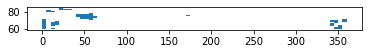

In [942]:
dg2=dg1[dg1.index.isin(l[:AA])]
dg2.plot()

In [943]:
dg3 = dg2.set_crs(ccrs.PlateCarree()).to_crs(ccrs.Orthographic(0, 90))

In [944]:
mpol = dg3.unary_union

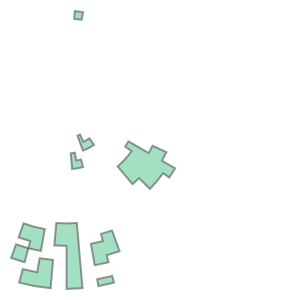

In [945]:
mpol

In [774]:
pols = list(mpol)

In [775]:
pols

In [776]:
pols_se = geopandas.GeoDataFrame(geometry=pols)

In [777]:
pols_se = pols_se[:]

In [778]:
pols_se['area'] = pols_se.area

In [779]:
ps1 = pols_se.sort_values('area')[::-1].reset_index(drop=True)

In [780]:
ps2=ps1.set_crs(ccrs.Orthographic(0, 90)).to_crs(ccrs.PlateCarree())

<AxesSubplot:>

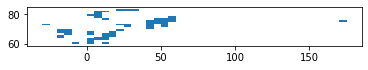

In [781]:
ps2['geometry'].plot()

In [782]:
from shapely import geometry

In [783]:
df= ds.to_dataframe()

In [784]:
i

35

In [785]:
dg3 = dg2.set_crs(ccrs.PlateCarree()).to_crs(ccrs.Orthographic(0, 90))

In [786]:
iv = {}
for i,v in dg3.representative_point().items():
    nn = ps1[ps1.contains(v)]
    n = nn.index[0]
    iv[i]=n

In [787]:
iv

{0: 3,
 23: 3,
 28: 3,
 50: 9,
 71: 3,
 129: 9,
 133: 3,
 232: 3,
 243: 13,
 272: 4,
 305: 1,
 314: 1,
 327: 1,
 388: 1,
 407: 1,
 475: 2,
 476: 1,
 540: 4,
 553: 1,
 578: 1,
 581: 12,
 621: 1,
 632: 2,
 660: 6,
 716: 0,
 756: 0,
 821: 0,
 837: 0,
 882: 5,
 901: 8,
 910: 11,
 913: 0,
 936: 10,
 966: 0,
 976: 7}

In [788]:
dss =ds.to_dataframe()

In [789]:
dss

lab  AIRTRACER
lon   lat    time                               
2.5   60.625 2019-09-20 09:00:00  837   0.000427
             2019-09-20 12:00:00  837   0.000354
             2019-09-20 15:00:00  837   0.000287
             2019-09-20 18:00:00  837   0.000290
             2019-09-20 21:00:00  837   0.000438
...                               ...        ...
357.5 89.375 2020-10-01 09:00:00  294   0.000007
             2020-10-01 12:00:00  294   0.000006
             2020-10-01 15:00:00  294   0.000010
             2020-10-01 18:00:00  294   0.000009
             2020-10-01 21:00:00  294   0.000213

[5220288 rows x 2 columns]

In [790]:
dss1 = dss[dss[L].isin(l[:AA])].copy()

In [791]:

NL = 'nl'

In [792]:
dss1[NL] = dss1[L].replace(iv)

In [793]:
dss2 = dss1.where(dss1[NL]<9)

In [794]:
ndf = dss2.reset_index().groupby([NL,'time'])[AT].sum().unstack().T

In [795]:
ndf

nl,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
time,,,,,,,,,
2019-09-20 09:00:00,0.002629,0.000647,0.000462,0.052635,0.000201,0.000185,0.000286,0.000157,0.000262
2019-09-20 12:00:00,0.002511,0.000888,0.000490,0.054713,0.000212,0.000190,0.000301,0.000159,0.000196
2019-09-20 15:00:00,0.002074,0.000833,0.000503,0.057972,0.000219,0.000187,0.000275,0.000151,0.000180
2019-09-20 18:00:00,0.002364,0.001161,0.000611,0.072214,0.000335,0.000220,0.000346,0.000148,0.000196
2019-09-20 21:00:00,0.003239,0.001840,0.000800,0.159968,0.000466,0.000334,0.000362,0.000211,0.000253
...,...,...,...,...,...,...,...,...,...
2020-10-01 09:00:00,0.003758,0.014641,0.001426,0.107502,0.001809,0.000528,0.000625,0.000279,0.000295
2020-10-01 12:00:00,0.003187,0.011639,0.001303,0.134260,0.001485,0.000522,0.000618,0.000265,0.000316
2020-10-01 15:00:00,0.004323,0.020198,0.001666,0.181615,0.002677,0.000689,0.000806,0.000289,0.000330


<AxesSubplot:xlabel='time'>

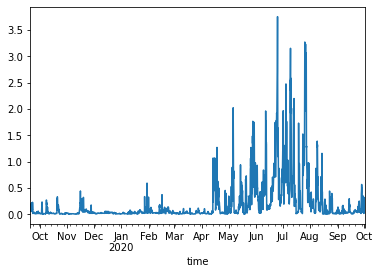

In [796]:
dss1.reset_index().groupby([NL,'time'])[AT].sum().unstack().sum().plot()

In [797]:
ndf.columns

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0], dtype='float64', name='nl')

In [798]:
ndm = ndf.copy()

In [799]:
ndm[PAR]=dm[PAR]

In [800]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet, LinearRegression

    c200 = ndf.columns

    X = ndm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = ndm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
#     
    regr = LinearRegression( positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
#     cdf = cdf/cdf.sum()

    r2=regr.score(XX[yn], y[yn])

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


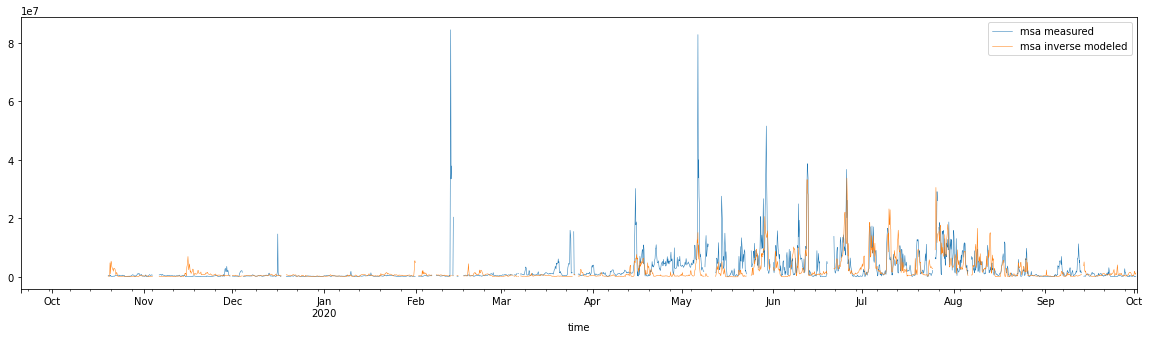

In [801]:
f,ax=plt.subplots(figsize=(20,5))
mod_ = (ndf/xn * cdf).sum(axis=1).where(yn)
ndm[PAR].where(yn).plot(label=f"{PAR} measured",lw=.5)
mod_.plot(label=f"{PAR} inverse modeled",lw=.5)
# plt.gca().set_yscale('log')
plt.gca().legend()

In [802]:
dum = pd.DataFrame()
dum['mea'] = ndm[PAR].where(yn)
dum['mod'] = mod_

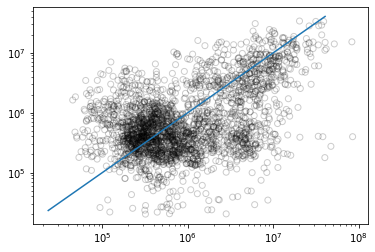

In [803]:
plt.scatter(dum['mea'],dum['mod'],alpha=.2, edgecolor='k', facecolor='none', )
ax= plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

q0, q1 = np.quantile([*dum[yn]['mea'].values,*dum[yn]['mod'].values], [.001, .999])

ax.plot(
    [q0, q1],
    [q0, q1],
    label=('1 to 1')
)

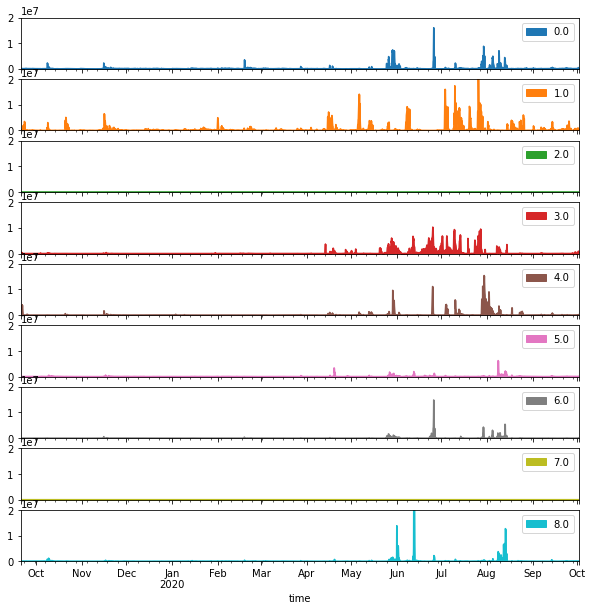

In [804]:
eight_=(ndf/xn * cdf)
eight_.plot.area(figsize=(10,10),subplots=True,sharey=True,ylim=(0,2.e7),cmap='tab10')
ax = plt.gca()

<AxesSubplot:>

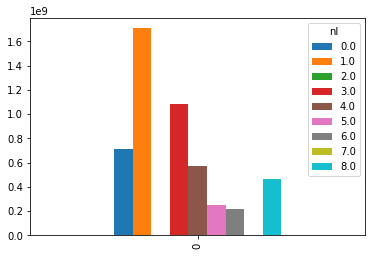

In [805]:
eight_.sum().to_frame().T.plot.bar(cmap='tab10')

<AxesSubplot:xlabel='nl'>

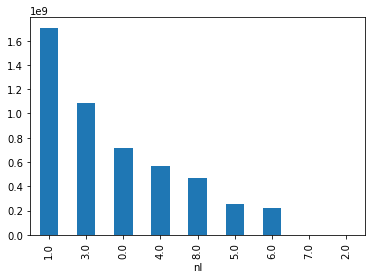

In [806]:
order = eight_.sum().sort_values()[::-1]
order.plot.bar()

In [807]:
eight_.to_csv('../data_out/eight_msa_sources_inverse.csv')

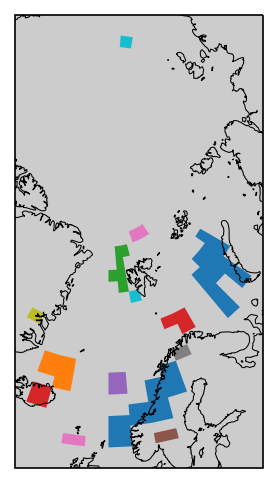

In [808]:
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.Orthographic(0, 90))
ax.coastlines(lw=.5)

(0.0, 90.0)

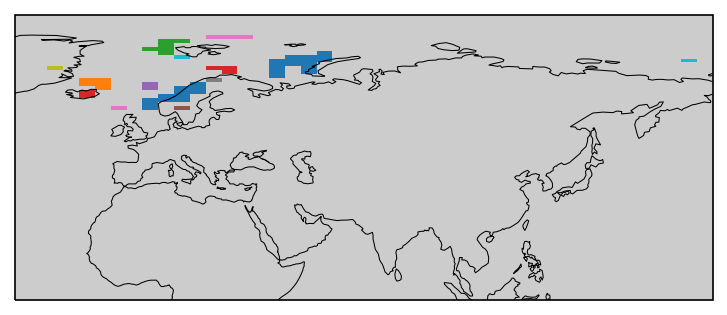

In [809]:
dic = dict(projection=ccrs.PlateCarree(), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.Orthographic(0, 90))
ax.coastlines(lw=.5)
ax.set_ylim(0,90)

In [137]:
dss1.to_xarray()[AT][{'time':2}]

<xarray.DataArray 'AIRTRACER' (lon: 34, lat: 13)>
array([[4.14232018e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [3.99644669e-05, 1.08371722e-04, 1.36693372e-04, 1.17103867e-02,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [4.89869562e-05, 1.13848124e-04, 1.18038901e-04, 3.63063999e-03,
        1.03157370e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [6.44159518e-05, 1.17111129e-04, 1.23705991e-04, 1.36835128e-03,
        1.27007006e-04, 1.27462859e-04, 1.38275776e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [8.02495124e-05,            nan,            nan, 5.24809642e-04,
        1.68134866e-04, 2.07272489e-04,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
...
       [           nan, 4.44617268e-04, 4.79671668e-04,            nan,
        3.22474167e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 1.36048431e-04, 1.55414775e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 3.25627479e-05,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 7.15211718e-05, 8.47575720e-05,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 3.45716035e-05, 6.31191433e-05,            nan,
        5.15876127e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 12.5 17.5 22.5 27.5 32.5 ... 217.5 222.5 242.5 247.5
  * lat      (lat) float64 83.12 60.62 61.88 88.12 ... 69.38 70.62 71.88 73.12
    time     datetime64[ns] 2019-09-20T15:00:00

In [242]:
#convert to mrakdown
!jupyter-nbconvert --to markdown z030_inverse_modeling_time_series.ipynb

[NbConvertApp] Converting notebook z030_inverse_modeling_time_series.ipynb to markdown
[NbConvertApp] Support files will be in z030_inverse_modeling_time_series_files/
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inv